# Results

Within this notebook, we load the results, and create the tables and plots for the paper. 

In [1]:
# we run the notebook in the root folder of the repo
%cd ..

/home/sherbold/git/sortbench


/home/sherbold/git/sortbench/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sortbench.util.eval_utils import normalize_metrics, compute_total_score

def plot_metrics(df_results, mode, metric_name, file=None):
    if mode == 'basic':
        type_names = ['Int-0:1000', 'Float-0:1000', 'English']
        
        _, axes = plt.subplots(3, 1, figsize=(6, 10))
        for i, type in enumerate(type_names):
            ax = axes[i]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', ax=ax)
            ax.set_title(type)
    elif mode == 'advanced':
        type_names = ['Integers-10000000:10001000',
                      'Int-n1000:1000',
                      'Float-10000000:10001000',
                      'Float-0:0.0001',
                      'Float-n1000-1000',
                      'ASCII-Lower',
                      'ASCII-Cased',
                      'PrfxEnglish',
                      'NumberWords']
        
        _, axes = plt.subplots(5, 2, figsize=(6, 10))
        for i, type in enumerate(type_names):
            row = i%5
            col = i//5
            ax = axes[row, col]
            df_results_type = df_results[df_results['Type'] == type]
            sns.lineplot(x='Size', y=metric_name, data=df_results_type, hue='Model', ax=ax)
            ax.set_title(type)
    plt.suptitle(metric_name)
    plt.tight_layout()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    else:
        plt.show()

def plot_aggregated_results(df_results, mode, file=None):
    metrics = ['SortBench Score', 'Validity Score', 'Sorting Score', 'Faithfulness Score']
    _, axes = plt.subplots(2, 2, figsize=(10,6))
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        df_results_mode = df_results[df_results['Mode'] == mode]
        sns.lineplot(x='Size', y=metric, data=df_results_mode, hue='Model', ax=ax)
        ax.set_title(f"{metric} ({mode})")
    plt.tight_layout()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')
    else:
        plt.show()

def aggregate_scores(df_results, mode):
    df_results_mode = df_results[df_results['Mode'] == mode]
    df_results_mode = df_results_mode[['Model', 'Size', 'SortBench Score', 'Sorting Score', 'Faithfulness Score', 'Validity Score']]

    results_per_size = df_results_mode.groupby(['Model', 'Size']).mean(numeric_only=True).reset_index()
    sum_of_sizes = results_per_size['Size'].unique().sum()
    results_per_size['Weighted SortBench Score'] = results_per_size['Size']*results_per_size['SortBench Score']
    results_per_size['Weighted Sorting Score'] = results_per_size['Size']*results_per_size['Sorting Score']
    results_per_size['Weighted Faithfulness Score'] = results_per_size['Size']*results_per_size['Faithfulness Score']
    results_per_size['Weighted Validity Score'] = results_per_size['Size']*results_per_size['Validity Score']
    results_per_model = results_per_size.groupby('Model').sum(numeric_only=True)[['Weighted SortBench Score', 'Weighted Sorting Score', 'Weighted Faithfulness Score', 'Weighted Validity Score']]/sum_of_sizes
    results_per_model = pd.DataFrame(results_per_model).sort_values('Weighted SortBench Score', ascending=False).reset_index()
    return results_per_model

\begin{tabular}{lrrrr}
\toprule
Model & SortBench Score & Sorting Score & Faithfulness Score & Validity Score \\
\midrule
gpt-4o & 0.985 & 0.988 & 0.982 & 0.967 \\
gpt-4o-mini & 0.950 & 0.981 & 0.918 & 0.956 \\
\bottomrule
\end{tabular}



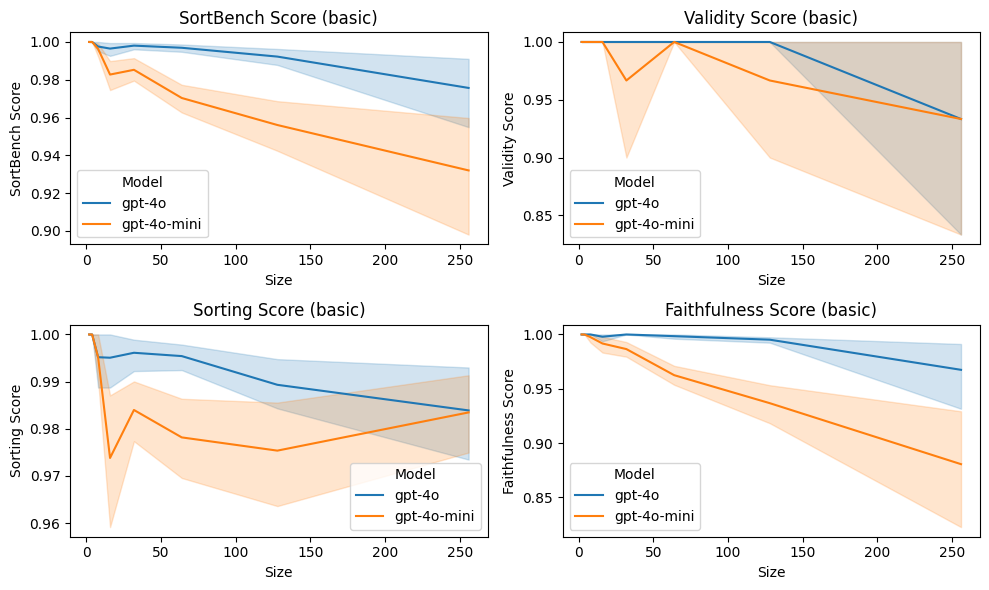

In [ ]:
def create_latex_table(results_per_model):
    latex_code = results_per_model.to_latex(index=False, float_format="%.3f")
    latex_code = latex_code.replace('Weighted ', '')
    return latex_code


benchmark_modes = ['basic'] # TODO add other modes later
version = "v1.0"

for mode in benchmark_modes:
    df_results = pd.read_csv(f'scores/scores_{mode}_{version}.csv')
    results_per_model = aggregate_scores(df_results, 'basic')
    print(create_latex_table(results_per_model))
    plot_aggregated_results(df_results, 'basic', file='figures/basic_aggregated_results.png')